In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.utils.data
!pip install torchsummary
from torchsummary import summary
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils
from torch.utils.data import DataLoader
import warnings
import random
import time
import fastprogress

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Python 3.7.12
1.9.1


# First part: Data Manipulation

In [3]:
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [4]:
device = get_device()
data_dir = "/kaggle/working/"

cuda available: True ; cudnn available: True ; num devices: 2
Using device Tesla T4


### Introducing a new class which will represent our multitask datasets

In [5]:
class MultitaskDataset(torch.utils.data.Dataset):
    def __init__(self, data, ntasks, nclasses = 10, multi_out = False):
        self.data = data
        self._current_task = 0
        self.ntasks = ntasks
        self.nclasses = nclasses
        self.multi_out = multi_out
        if multi_out:
            self.__init_output_masks__()
    @property
    def current_task(self):
        return self._current_task 
    
    def __init_output_masks__(self):
        self.masks = []
        for k in range(len(self.data)):
            mask = np.zeros((self.nclasses,))
            for x,y in self.data[k]:
                mask[y] = 1.0
            output_mask = torch.from_numpy(mask)
            self.masks.append(output_mask)
            
    @property
    def current_mask(self):
        if self.multi_out:
            return self.masks[self._current_task]
        else:
            return torch.tensor([1.0 for k in range(self.nclasses)])
    
    def __getitem__(self,key):
        if self.data is not None:
            return self.data[self._current_task][key]
        else:
            warnings.warn("The dataset is empty, fill it before accessing it")
            return 0
        
    def __len__(self):
        """
        Returns the length of the current dataset
        """
        return len(self.data[self._current_task])
    
    @property
    def lengths(self):
        """
        Returns an array with the list of lengths of each dataset
        """
        return [len(self.data[i]) for i in range(self.ntasks)]
    
    def go_next(self):
        """
        Goes to the next task
        """
        self._current_task +=1
        if self._current_task >= self.ntasks:
            self._current_task = 0
        return self._current_task
    
    def task(self,task_n):
        """
        Goes to the specified task
        """
        if task_n in range(self.ntasks):
            self._current_task = task_n
        else:
            warnings.warn("The selected task is not availble, setting it to default: 0")
            self._current_task = 0

In [6]:
# utils.py
def grab_data(data_dir, name, **kwargs):
    trainset = torchvision.datasets.MNIST(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples)
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))
    print("mean:",dataset_mean,"std",dataset_std)
    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])
    trainset = datasets.MNIST(data_dir, train = True, download=True, transform = normalized_transform)
    testset = datasets.MNIST(data_dir, train = False, download=True, transform = normalized_transform)
    if name == "splitMNIST":
        return preprocess_split(trainset), preprocess_split(testset)
    elif name == "shuffledMNIST":
        ntasks = kwargs["ntasks"] if "ntasks" in kwargs.keys() else 5 
        return preprocess_shuffle(trainset, ntasks = ntasks), preprocess_shuffle(testset, ntasks = ntasks)
    else:
        raise NotImplementedError
    
def preprocess_split(dataset, order = "num"):
    """Splits the MNIST dataset into 5 different categories to be
        used for training on the splitMNIST dataset

        Args:
            dataset (torch.utils.data.Dataset): dataset to split
            order (str, optional): either "num" or "rand", defines the 
                order in which we want to group the numbers in different
                categories, numerically or randomly
        Returns:
            MultitaskDataset: a dataset containing all the split tasks
    """
    data = [[] for k in range(5)]
    ntasks = 5
    if order == "num":
        o = [0,1,2,3,4]
        n = [0,1,2,3,4,5,6,7,8,9]
    elif order == "rand":
        o = random.sample([0,1,2,3,4],5)
        n = random.sample([0,1,2,3,4,5,6,7,8,9],10)
    for sample in dataset:
        l = sample[1]
        if l == n[0] or l == n[1]:
            data[o[0]].append(sample)
        elif l == n[2] or l == n[3]:
            data[o[1]].append(sample)
        elif l == n[4] or l == n[5]:
            data[o[2]].append(sample)
        elif l == n[6] or l == n[7]:
            data[o[3]].append(sample)
        else:
            data[4].append(sample)
    return MultitaskDataset(data, 5, nclasses = ntasks*2, multi_out = True)


def preprocess_shuffle(dataset, ntasks = 5):
    """Shuffles the pixels in the MNIST dataset into [ntasks (max. 10)] different categories 
        to be used for training on the shuffledMNIST dataset.
        The seeds are kept consistent throughout calls, which allows for creation
        of automatically consistent training and test dataset.

        Args:
            dataset (torch.utils.data.Dataset): dataset to split
            ntasks: number of tasks to be created for the new dataset
        Returns:
            MultitaskDataset: a dataset containing all the split tasks
    """
    def shuffle_pixels(seed, data):
        """
          Shuffles the pixels of the images in a dataset given a seed for the randomizer
          In this implementation we don't use this, but let's just keep it because it might come in handy later on.
        """
        new_data = []
        # Get the shape of the input image
        shape = data[0][0].shape
        for i,x in enumerate(data):
            # Using numpy arrays seems to be much faster than for tensors
            y = torch.flatten(x[0]).numpy()
            random.Random(seed).shuffle(y)
            y = torch.from_numpy(np.reshape(y,shape))
            new_data.append((y,x[1]))
            if i % 10000 == 0:
                print("Went over",i,"samples")
        return new_data
    # Define the standard random seeds to be used for generation
    seeds = [15,42,57,1,98,105,1275,2,17,58]
    data = []
    print("Shuffling for ntasks:", ntasks)
    for seed in seeds[:ntasks]:
        print("Creating shuffle for seed", seed)
        data.append(shuffle_pixels(seed, dataset))
        print("Correctly created")
    return MultitaskDataset(data, ntasks, nclasses = 10)

## Importing and checking the datasets

In [7]:
ntasks = 5
file_train = "/kaggle/working/traindata.set"
file_test = "/kaggle/working/testdata.set"
if os.path.isfile(file_train) and os.path.isfile(file_test):
    print("Files found, loading datasets")
    traindata = torch.load(file_train)
    testdata = torch.load(file_test)
    print("Correctly loaded")
else:
    print("Datasets do not exist, creating them")
    traindata, testdata = grab_data(data_dir, "splitMNIST", ntasks = ntasks)
    torch.save(traindata, file_train)
    torch.save(testdata, file_test)

Datasets do not exist, creating them


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


mean: tensor([0.1307]) std tensor([0.3081])


In [8]:
#TODO: Generate a validation data split   

In [9]:
# So, in the simulations it seems that 128 is better than 64 for splitMNIST, 64 is slower and doesn't perform significantly better
batch_size = 128
trainloader = torch.utils.data.DataLoader(traindata, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testdata, batch_size = batch_size, shuffle = True)

5


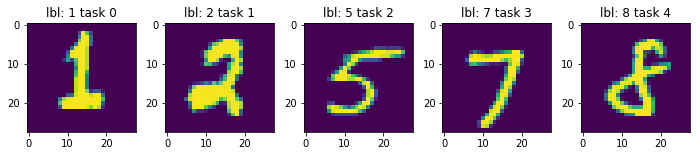

In [10]:
print(traindata.ntasks)
fig, ax = plt.subplots(1,5, figsize = (12,2))
for i in range(5):
    ims,lbls = next(iter(trainloader))
    ax[i].imshow(torch.squeeze(ims[1]).numpy())
    ax[i].set_title("lbl: " + str(lbls[1].item()) + " task " + str(traindata.current_task))
    traindata.go_next()
fig.show()

In [11]:
print(trainloader.dataset.current_mask)
print(trainloader.dataset.nclasses)

tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
10


# Second part: Defining the model

In [12]:
# utils.py
class CascadeSequential(nn.Sequential):
    def __init__(self,*args):
        """
        Initialize the CascadeSequential like a normal Sequential model.
        
        AFTER specifying your sequential architecture you should initialize
        the extra parameters by calling model.init_params. 
        
        If you call init_params (also possible) BEFORE specifying your layers 
        then you should call model.init_cascade after having done that.
        """
        super().__init__(*args)
    
        
    def init_params(self, nlayers = 4, c0 = 2, g0 = 2, tau = 1, init_method = 'clone', **kwargs):
        self.g = self.__init_g__(nlayers, g0)
        self.C = self.__init_C__(nlayers, c0)
        self.nlayers = nlayers
        self.cascade = None
        self.tau = tau
        if len(self) != 0:
            self.init_cascade(init_method, **kwargs)
        
        else:
            print("No layers have been detected, cascade will not be initialized")
    
    def __init_g__(self,n, g0):
        g = np.zeros(len(range(0,n+1))).astype(np.float32)
        for i in range(0, n+1):
            g[i] = (g0**(-i-1))
        return g
    
    def __init_C__(self,n,C0):
        C = np.zeros(len(range(0,n+1))).astype(np.float32)
        for i in range(0, n+1):
            C[i] = (C0**(i))
        return C
    
    def init_cascade(self, init_method, **kwargs):
        if sum(p.numel() for p in self.parameters()) == 0:
            raise AttributeError("The model has no parameters, before initializing the cascade you must initialize the model weights")
        # Now actually initialize the cascade
        self.n_param_layers = sum(1 for p in model.parameters()) 
        # Setting up the tau mask (this opens the possibility to use different time constants for different layers!)
        self.tau = self.tau * torch.ones(self.n_param_layers)
        # Resetting tau to a mask for which layers we'll actually use in case 
        # the cascade is not implemented on all of them.
        if "layers" in kwargs.keys():
            tmp = self.tau[0].item()
            self.tau[:] *= 0
            self.tau[kwargs["layers"]] += tmp
        self.cascade = [[] for k in range(self.n_param_layers)]
        for i,params in zip(range(self.n_param_layers),model.parameters()):
            # We make two extra copies of the weights which will be useful in cascade_step
            for k in range(self.nlayers+2):
                # This initialization can be played with
                self.cascade[i].append(params.clone().detach())
                if init_method == 'clone':
                    self.cascade[i][k] *= self.init_multiplyer
                elif init_method == 'xavier':
                    if len(self.cascade[i][k].shape)>= 2:
                        torch.nn.init.xavier_uniform_(self.cascade[i][k])
                    else:
                        self.cascade[i][k] *= 0.0
                elif init_method == 'exp':
                    self.cascade[i][k]*= self.init_multiplyer**(k+1)
            # This trick allows for leakage from the last layer of the cascade
            # Covers the case n = nlayers-1 in the cascade_step function
            self.cascade[i][self.nlayers] *= 0.0
        if "verbose" in kwargs.keys() and kwargs["verbose"] == True:
            print(f"Cascade with {self.nlayers} layers has been initialized")
            
    def to(self, *args,**kwargs):
        # First use the normal model.to
        super().to(*args,**kwargs)
        # Then apply the same to the cascade
        for i in range(len(self.cascade)):
            for k in range(self.nlayers+2):
                self.cascade[i][k] = self.cascade[i][k].to(*args,**kwargs)
                #print(self.cascade[i][k].device)
    
    def cascade_step(self):
        # Just to make sure no gradients are accounted for in this step
        with torch.no_grad():
            for i, params in zip(range(self.n_param_layers), self.parameters()):
                # Update the last layer to copy the weights ([n-1] = -1 covers n=0)
                params += self.tau[i]/self.C[0]*self.g[0]*(self.cascade[i][0]-params)
                self.cascade[i][-1] = params.clone().detach()
                # Trying to get rid of the leakage to see if I can work around it
                self.cascade[i][self.nlayers] = self.cascade[i][self.nlayers-1]
                changes = [[] for k in range(self.nlayers)]
                for n in range(self.nlayers):
                    changes[n] = self.tau[i]/self.C[n+1]*(self.g[n]*(self.cascade[i][n-1]-self.cascade[i][n])
                                                   + self.g[n+1]*(self.cascade[i][n+1]-self.cascade[i][n]))
                for n in range(self.nlayers):
                    self.cascade[i][n] += changes[n]
                    

### Some notes on previous errors that I got, just in case something similar happens again.

Ok something cool:
At the start of the experiment I set the cascade to be a copy of the weights, so when I compute the gradient the cascade part gives no contribution, and in fact if I just repeat the same experiment using only the crossentropy loss (with a halved learning rate), then I get exactly the same result. So then what I have to do is do 2 time steps: in the first one I only use CrossEntropy, and in the second one I actually implement the cascade dynamics.
Ok it does not compute the gradient correctly over the cascade part of the loss.

I should try to separate the loss in two losses so that I can see the gradients computed from each loss and see if they correspond to each other, because right now I have no way of checking that they're actually the same (even though it does look like the order of magnitude is the same)

Okay I do need to retain the graph because when the loss is backpropagated the nodes corresponding to the cascade are deleted, which means that on the next call when we backpropagate we're referencing something that is not part of the network used for backprop anymore. An alternative would be to find a way to create these nodes in another way by creating pytorch variables associated with the cascade, but not sure how to do that for now.

Okay it does seem like something weird happens in the "optimizer.step()" function because before doing that the values of the gradients are exactly the same but then if I change the weights manually or if I assign the full loss to the optimizer there are differences arising (order of 1e-9) in the values of the weights after updates. Or maybe there is some leakage from the "torch.no_grad()" and the optimizer is registering some change in the weights? Consider asking on pytorch forum.

Just to be sure check that the results remain consistent over a few more timesteps.

There's something very weird going on: if I initialize the cascade at different percentages of "fullness" of the weights themselves the calculations for the gradients don't actually match (there seems to be an actual functional relationship though!), now going to look at what kind of relationship there is between the two to see what's going on.

Definitely weird!!! Soo, the functional relationship is $$\frac{autograd(c,w)}{manualgrad(c,w)} = 1 - \frac{c_0}{w_0}$$

Also! The timescale Tau makes actually a very big difference, if it's too big the system goes into crazy oscillations and diverges, need to try out different values!

OOOOOKAYYYYY! I solved it, the problem was that I had to call the .detach() function as soon as I clone the parameters in the cascade. In fact what the autograd was seeing was not the difference btw the cascade and the weights, but instead it was seeing:
$$(w\cdot a - w)^2 \Longrightarrow \frac{dL}{dw} = -2w(a-1)^2$$
Where a is the initial value (as a percentage) that I create the cascade params with. Which is consistent with what I was seeing.

# Defining some required methods

In [13]:
def update_output_mask(labels, ntasks = 10):
    mask = np.zeros((ntasks,))
    for l in labels:
        #print(l)
        mask[l] = 1.0
    output_mask = torch.from_numpy(mask)
    return output_mask

class Masked_Softmax(nn.Module):
    """A masked softmax for multi-output networks.
        
        Params:
            output_mask (torch.Tensor): a tensor representing the mask
                that should be applied on the output before using softmax.
                The default is a torch.ones() so that no mask is applied and
                the module acts as a simple (but less efficient) softmax.
        """
    def __init__(self, n_outs):
        """
        Args: 
            n_outs (int): The number of units in the output layer.
        """
        super().__init__()
        self.output_mask = torch.ones((n_outs,))
        self.name = "masked_softmax"
    
    def masked_softmax(self, logits):
        # logits are [batch_size, output_dim]
        x = torch.where(torch.tile(torch.eq(self.output_mask[None, :], 1.0), [logits.shape[0], 1]), logits, -1e32 * torch.ones_like(logits))
        return F.softmax(x, dim = 1)
    
    def forward(self,x):
        return self.masked_softmax(x)
# Just some tests
output_mask = update_output_mask([np.array([1,0,0,0,0,0,0,0,0,0]),np.array([0,1,0,0,0,0,0,0,0,0])])
print(output_mask)
M = Masked_Softmax(10)
M.output_mask = output_mask
logit = torch.stack([torch.tensor([0.5,0.8,1,0.2,0,0,0,0,0,0]),torch.tensor([0.7,0.1,1,0.2,0.1,0,0,0,0,0]),torch.tensor([0.2,0.6,1,0.2,0,0,0,0,0,0])])
print(M(logit))

tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
tensor([[0.4256, 0.5744, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.6457, 0.3543, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4013, 0.5987, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])


In [14]:
def accuracy(correct, total):
    return float(correct)/total

# First tests with a model, checking that the functions above work
Also here try to see the difference for training with autograd and without, just to see if they behave the same. Also, check which way is more efficient, because if the manual way is the more efficient one then just go with it and forget about the autograd.

In [15]:
def select_random_weights(model, num_weights):
    """Select *num_weights* weights of the network and return their indices.
    
        Args:
            model (nn.Module): the model from which the indices are to be selected
            num_weights (int): The number of weights to be selected
        Returns:
            list(list(tuple(int))): [a list of the indices that were selected for params in model.parameters()]
    """
    indices = []
    for params in model.parameters():
        tmp = [np.expand_dims(random.sample(range(params.shape[k]),num_weights),1) for k in range(len(params.shape))]
        indices.append(np.concatenate(tmp,axis = 1))
    return indices

def take_cascade_snapshot(model, indices):
    """Takes a snapshot of the various cascade parameters of the given model given a set of indices
    
        Returns:
            list(list(torch.tensor)): the copies from each layer of the model, of the params in each layer in the cascade.
                                The tensor has shape (num_weights,num_cascade_layers + 1).
    """
    snap = []
    for i, idx, params in zip(range(model.n_param_layers), indices, model.parameters()):
        # Due to python indexing I need to separate into different cases, probably there's a better way
        if len(idx[0]) == 1:
            c_layers = []
            for n in range(model.nlayers + 1):
                if n == 0:
                    tmp = torch.tensor([params[idx[l]].item() for l in range(len(idx))])
                elif n != 0:
                    tmp = torch.tensor([model.cascade[i][n-1][idx[l]].item() for l in range(len(idx))])
                c_layers.append(tmp)
            snap.append(torch.stack(c_layers))
        elif len(idx[0]) == 2:
            c_layers = []
            for n in range(model.nlayers + 1):
                if n == 0:
                    tmp = torch.tensor([params[idx[l,0],idx[l,1]].item() for l in range(len(idx))])
                else:
                    tmp = torch.tensor([model.cascade[i][n-1][idx[l,0],idx[l,1]].item() for l in range(len(idx))])
                c_layers.append(tmp)
            snap.append(torch.stack(c_layers))
        else:
            raise NotImplementedError("For now only accepting 1 or 2 dimensional weights")
    return torch.stack(snap).unsqueeze(3)

### Example code for taking snapshots of random weights in the network

In [16]:
n_units = 10
model = CascadeSequential(
                nn.Flatten(),
                nn.Linear(20, n_units),
                nn.ReLU(),
                nn.Linear(n_units, 10),
                Masked_Softmax(10)
        )
init = 'clone'
model.init_multiplyer = 1 if init=='clone' else 0.5
#print("optimal cascade layers:", nlayers)
model.init_params(nlayers = 2, tau = 0, init_method ='xavier')
idx = select_random_weights(model,10)

snapsy = []
for j in range(20):
    snaps = []
    for k in range(10):
        snap = take_cascade_snapshot(model,idx)
        snaps.append(snap)
    snapsy.append(torch.cat(snaps,dim = 3))
snapsy = torch.cat(snapsy,dim = 3)
print(snapsy.shape)

torch.Size([4, 3, 10, 200])


# Training routines

In [17]:
def c_evolve(model, steps = 1, **kwargs):
    # Risky but faster
    tmp = model.tau
    if "evolve_layers" in kwargs.keys():
        tau = np.zeros(model.n_param_layers)
        tau[kwargs["evolve_layers"]] = model.tau[kwargs["evolve_layers"]]
        model.tau = tau
    for j in range(steps):
        model.cascade_step()
    # Reset the tau to its true value
    model.tau = tmp
    
def train(dataloader,model,optimizer, device, master_bar, loss_fn, snap_idx = None, **kwargs):
    """Run one training epoch for a single task. Also offers the possibility to track some of the weights
        and corresponding layers in the cascade. It's also possible to evolve the cascade at the end of each epoch
        or after every batch of the dataset.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress
        snap_idx (list): A list of indices of the random weights to be tracked, the ones returned
            by the function select_random_weights() are in the correct format.

    Returns:
        float, list: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy) for all tasks
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    snapshot = []
    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        master_bar.child.comment = f"batch"
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))
        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())
        # Backward pass
        loss.backward()
        optimizer.step()
        model.cascade_step()
        if snap_idx is not None:
            snapshot.append(take_cascade_snapshot(model, snap_idx))
        
        # Evolve the cascade after each batch of data has been processed 
        if "evolve_cascade_pb" in kwargs.keys():
            steps = kwargs["evolve_cascade_pb"]
            c_evolve(model, steps, **kwargs)
            if snap_idx is not None:
                snapshot.append(take_cascade_snapshot(model, snap_idx))
    # Evolve the cascade at the end of the epoch
    if "evolve_cascade_pe" in kwargs.keys():
        steps = kwargs["evolve_cascade_pe"]
        master_bar.main_bar.comment = f"Evolving cascade ..."
        for j in range(steps):
            # Since we want to look at what happens during this time
            c_evolve(model, 1, **kwargs)
            if snap_idx is not None:
                snapshot.append(take_cascade_snapshot(model, snap_idx))
        master_bar.main_bar.comment = f""
    snapshot = torch.cat(snapshot,dim=3) if len(snapshot) > 0 else None
    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), compute_metrics(dataloader, model, device, loss_fn, compute_loss = False), snapshot


def validate(dataloader, model, device, master_bar, loss_fn):
    """Run validation on the dataset
    
    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, list: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy) for all tasks
        
    """
    # Return the mean loss and the accuracy of this epoch
    return compute_metrics(dataloader, model, device, loss_fn, master_bar = master_bar, compute_loss = True)


def compute_metrics(dataloader, model, device, loss_fn, compute_loss = True, master_bar = None):
    """Compute the metrics for the current epoch on all tasks, and then resets the
        dataset to the task in which it was set before metrics computation (useful for multitask training)
    
    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to evaluate
        device (torch.device): Torch device to use for training
        compute_loss (bool, optional): Whether the function should also compute
            the loss or not. Defaults to True. 
        master_bar (fastprogress.master_bar, optional): Will be iterated over for each
            epoch to draw batches and display training progress. Defaults to None.
    
    Returns:
        list, list : Loss and accuracies across all tasks in the dataset.
                     OR (compute_loss = False)
        list : Only accuracies across all tasks in the dataset. 
    """
    epoch_acc = []
    epoch_loss = []
    task = dataloader.dataset.current_task
    if master_bar is not None:
        bar = fastprogress.progress_bar(range(dataloader.dataset.ntasks), parent = master_bar)
    else:
        bar = range(dataloader.dataset.ntasks)
    model.eval()
    with torch.no_grad():
        # Start computing metrics from task 0
        dataloader.dataset.task(0)
        for k in bar:
            # Important is to make sure the mask is on the right device
            model[-1].output_mask = dataloader.dataset.current_mask.to(device)
            correct, total = 0, 0
            e_l = []
            for x, y in dataloader:
                y_pred = model(x.to(device))
                
                correct += sum(y.to(device) == y_pred.argmax(dim=1))
                total += len(y)

                if compute_loss:
                    loss = loss_fn(y_pred,y.to(device))
                    e_l.append(loss.item())
            if compute_loss:
                epoch_loss.append(np.mean(e_l))
            epoch_acc.append(accuracy(correct, total))
            # Go to next task and repeat
            dataloader.dataset.go_next()
        # Returns
        if compute_loss:
            dataloader.dataset.task(task)
            return epoch_loss, epoch_acc
        else:
            dataloader.dataset.task(task)
            return epoch_acc
            
            
def multitask_training(model, optimizer, loss_fn, device, num_epochs, 
                train_dataloader, val_dataloader, verbose=False, validation = True, track_cascade = False, **kwargs):
    """Run model training on multiple tasks.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn : Torch loss function for training, which is added to the cascade loss in case it's present. (to be generalized!!)
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        verbose (bool, optional): Print information about model training. 
            Defaults to False.
        

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    # Initialize variables
    start_time = time.time()
    snapshots = []
    full_weight_snaps = []
    init_lr = model.lr
    t = 0
    if track_cascade:
        snap_indices = select_random_weights(model,10)
    # Make sure that we start from task 0 (it shouldn't cause problems anyways because of how I set up the dataset class, but it's better for clarity)
    train_dataloader.dataset.task(0)
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    
    # Iterate over the tasks
    for k in range(train_dataloader.dataset.ntasks):
        # Set the output mask for the softmax layer (in the case of single-head it does not have any effect)
        model[-1].output_mask = train_dataloader.dataset.current_mask.to(device)
        task_start_time = time.time()
        if verbose:
            print(f"Training on task n. {train_dataloader.dataset.current_task}")
        # Iterate over epochs of training
        for epoch in master_bar:
            # In order to initialize the cascade in a good state copy the values
            # of the weights after learning the first task
            if "copy_cascade_after_epoch" in kwargs.keys():
                model.tau = 0
                if epoch == kwargs["copy_cascade_after_epoch"][0]:
                    model.init_multiplyer = 1.0
                    model.tau = kwargs["copy_cascade_after_epoch"][1]
                    model.init_cascade('clone')
                    print("The cascades have been re-initialized")
                    del kwargs["copy_cascade_after_epoch"]
                    
            # Train the model
            epoch_train_loss, epoch_train_acc, snapshot = train(train_dataloader, model, optimizer,
                                                                device, master_bar, loss_fn = loss_fn, 
                                                                snap_idx = snap_indices if track_cascade else None, **kwargs)
            
            # Implement cosine lr-scheduling to decrease efffect of new data on the network
            if kwargs.get("lr_decay", False):
                model.lr = 0.5*init_lr*(1 + np.cos(t*np.pi/(num_epochs*train_dataloader.dataset.ntasks)))
                if verbose:
                    print(f"lr changed to {model.lr}")
                t += 1
                
            if validation == True:
                # Validate the model
                epoch_val_loss, epoch_val_acc = validate(val_dataloader, model,
                                                        device, master_bar, loss_fn = loss_fn)
                val_losses.append(epoch_val_loss)
                val_accs.append(epoch_val_acc)

            # Save loss and acc for plotting
            train_losses.append(epoch_train_loss)
            train_accs.append(epoch_train_acc)
            # Save the snapshots of the randomly selected weights and cascade
            snapshots.append(snapshot)
            
            # Plot in real time the validation accuracies
            if kwargs.get("plot_rt", False):
                master_bar.names = range(trainloader.dataset.ntasks)
                t_a = np.array(train_accs)
                data = []
                for z in range(trainloader.dataset.ntasks):
                    data.append([range(len(t_a[:,z])),t_a[:,z]])
                master_bar.update_graph(data)
                    
            # Print accuracies (needs to be formatted correctly, now it sucks)
            if verbose:
                if validation:
                    master_bar.write(f'Train loss: {epoch_train_loss}, val loss: {epoch_val_loss}, train acc: {epoch_train_acc}, val acc {epoch_val_acc}')
                else:
                    master_bar.write(f'Train loss: {epoch_train_loss:.2f}, train acc: {epoch_train_acc:.3f}')
                    
        # Save a snapshot of the weights of the network after training a task
        full_weight_snaps.append([params.clone().detach().tolist() for params in model.parameters()])
        time_elapsed = np.round(time.time() - task_start_time, 0).astype(int)
        
        if verbose:
            print(f'Finished task {trainloader.dataset.current_task} after {time_elapsed} seconds.')
        # Put the dataset in the next task
        train_dataloader.dataset.go_next()
        
        # In case we're using the Adam optim, reset it to avoid keeping memory of past tasks!
        if kwargs.get("adam", False):
            optim = torch.optim.Adam(model.parameters(), lr = model.lr)
        
    total_time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Total training time was {total_time_elapsed} s.')
    
    # Save the data from the weights and cascades into a dictionary
    if snapshots[0] is not None:
        snapshots = torch.cat(snapshots, dim = 3)
    data = {
        "full_weight_snaps": full_weight_snaps,
        "cascade_evolution": snapshots
    }
    
    # Returns
    if validation:
        return train_losses, val_losses, train_accs, val_accs, data
    else:
        return train_losses, train_accs, data


In [18]:
class FakeCascadeSequential(nn.Sequential):
    """I make this class only for it to be compatible with the training algorithm that we defined above
        In practice it's simply a Sequential with some dummy variables.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_params(self, *args, **kwargs):
        pass
    
    def cascade_step(self):
        pass
    
def find_optimal_layer_n(model):
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    for i in range(0, n_params):
        if 2**(2*i+1) >= n_params:
            return i
def plot_params(data, nlayers):
    return 0
    for l in range(len(data["cascade_evolution"][:,0,0,0])):
        fig, ax = plt.subplots(2,5, figsize = (30,8))
        #print(data["cascade_evolution"].shape)
        for k in range(10):
            for j in range(nlayers):
                ax[int(k/5)][k if k<5 else k-5].plot(data["cascade_evolution"][l, j,k,:], label = j)
            ax[int(k/5)][k if k<5 else k-5].legend()
        fig.suptitle(f"Layer {l}", fontsize = 15)
def plot_accuracy(acc_array):
    t_a = np.array(acc_array)
    plt.figure(figsize = (7,7))
    for k in range(5):
        plt.plot(t_a[:, k])
    plt.grid(True)
    plt.title("Accuracy over epochs", fontsize = 15)
    plt.show()

- Accuracy & metrics
- Training routine
- generalize training to case without cascade.
- plot function
- maybe let's try to avoid using biases to try out different initializations


# First actual tests with the datasets

In [19]:
val_acc, val_l, tr_acc, tr_l, datas, weight_snaps = [], [], [], [], [], []
myvals = []
data_dict = {}

# Without cascade - Adam (Zenke et al.)

In [20]:
# The best accuracy I can get here is with lr = 1e-2 using SGD
n_units = 256
lr = 1e-3
myvals = []
data_dict = {}
for k in range(4):
    # Initialize model and params
    model = FakeCascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 0.8
    nlayers = find_optimal_layer_n(model)
    print("optimal cascade layers:", nlayers)
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.Adam(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, 10, trainloader, testloader, verbose = False, adam = True)
    myvals.append(np.array(v_a)[-1,:])
    data_dict[f"adam_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
plot_accuracy(t_a)

In [21]:
import json
# # Just an attempt to make sure that saving works, this way I don't have to wait for the 
# # entire script to run
# with open(data_dir+"prova.json","w+") as file:
#     json.dump(data_dict,file)

In [22]:
myvals = np.array(myvals)
plt.figure(figsize=(8,5))
plt.errorbar(range(0,5), np.mean(myvals, axis = 0), yerr = np.var(myvals,axis=0), marker = '.', markersize = 15)
plt.xticks(range(0,5),["0 or 1", "2 or 3", "4 or 5", "6 or 7","8 or 9"], fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Average accuracy per task", fontsize = 20)
plt.show()

# Without cascade - SGD

In [23]:
# The best accuracy I can get here is with lr = 1e-2 using SGD
n_units = 256
lr = 1e-2
myvals = []
for k in range(4):
    # Initialize model and params
    model = FakeCascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 0.8
    nlayers = find_optimal_layer_n(model)
    print("optimal cascade layers:", nlayers)
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, 10, trainloader, testloader, verbose = False, adam = False)
    data_dict[f"SGD_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
    myvals.append(np.array(v_a)[-1,:])
plot_accuracy(t_a)

In [24]:
print("Average without the cascade:", np.mean(np.array(v_a)[-1,:]))

# Cascade without any tweakings, timescale as in Benna & Fusi

In [25]:
# Some parameters
n_units = 256
lr = 0.5
init_methods = ['clone']#, 'xavier', 'exp']
tau = 0.25
epochs = 10
# Initialize model and params
for k in range(4):
    model = CascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 1 
    nlayers = find_optimal_layer_n(model)
    print("optimal cascade layers:", nlayers)
    model.init_params(nlayers = nlayers, tau = tau, init_method ='clone')
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                                  trainloader, testloader, 
                                                  verbose = False, track_cascade = True if k==0 else False, 
                                                  plot_rt = True)
                                                  #copy_cascade_after_epoch = (3,0.25),
    if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
    data_dict[f"naive_cascade_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data,"lr":lr}
    weight_snaps.append(data["full_weight_snaps"])
    v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
    datas.append(data)
    val_acc.append(v_a)
    tr_acc.append(t_a)
    val_l.append(v_l)
    tr_l.append(t_l)
    
plot_params(data, nlayers)

In [26]:
# print("Average accuracy fast cascade:", np.mean(v_a[-1,:]))

# Cascade with very fast timescale

In [27]:
# Some parameters
n_units = 256
lr = 0.5
init_methods = ['clone']#, 'xavier', 'exp']
tau = 3
epochs = 10
# Initialize model and params
model = CascadeSequential(
        nn.Flatten(),
        nn.Linear(28*28, n_units),
        nn.ReLU(),
        nn.Linear(n_units, n_units),
        nn.ReLU(),
        nn.Linear(n_units, 10),
        Masked_Softmax(10)
)
model.init_multiplyer = 1 
nlayers = find_optimal_layer_n(model)
print("optimal cascade layers:", nlayers)
model.init_params(nlayers = nlayers, tau = tau, init_method ='clone')
model.lr = lr
#print(device)
model.to(device)
#print(model.cascade[0][1].device)
optim = torch.optim.SGD(model.parameters(), lr = lr)
loss = nn.CrossEntropyLoss()
# Run training
t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                              trainloader, testloader, 
                                              verbose = False, track_cascade = True, 
                                              plot_rt = True)
                                              #copy_cascade_after_epoch = (3,0.25),                                     
weight_snaps.append(data["full_weight_snaps"])
v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
datas.append(data)
val_acc.append(v_a)
tr_acc.append(t_a)
val_l.append(v_l)
tr_l.append(t_l)
plot_params(data, nlayers)

In [28]:
#print("Average accuracy faster cascade:", np.mean(v_a[-1,:]))

# Trying to wait at the end of each epoch to allow the cascade to settle a little and "process" the information received

In [29]:
# Some parameters
n_units = 256
lr = 0.5
init_methods = ['clone']#, 'xavier', 'exp']
tau = 0.25
epochs = 10
epoch_steps = 1000
# Initialize model and params
for k in range(4):
    model = CascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 1 
    #==== Lower the number of cascade layers to allow settling in one state =====
    nlayers = 5
    # =========
    print("optimal cascade layers:", nlayers)
    model.init_params(nlayers = nlayers, tau = tau, init_method ='clone')
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                                  trainloader, testloader, 
                                                  verbose = False, track_cascade = True if k==0 else False, 
                                                  plot_rt = True, evolve_cascade_pe = epoch_steps)
                                                  #copy_cascade_after_epoch = (3,0.25),
    if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
    data_dict[f"epoch_wait_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
    weight_snaps.append(data["full_weight_snaps"])
    v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
    datas.append(data)
    val_acc.append(v_a)
    tr_acc.append(t_a)
    val_l.append(v_l)
    tr_l.append(t_l)
    
plot_params(data, nlayers)

In [30]:
# print("Average accuracy epoch waiting:", np.mean(v_a[-1,:]))

# Waiting at each batch step to allow more information processing

In [31]:
# Some parameters
n_units = 256
lr = 0.5
init_methods = ['clone']#, 'xavier', 'exp']
tau = 0.25
epochs = 10
epoch_steps = 0
batch_steps = 200
# Initialize model and params
for k in range(4):
    model = CascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 1 
    nlayers = 5
    print("optimal cascade layers:", nlayers)
    model.init_params(nlayers = nlayers, tau = tau, init_method ='clone')
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                                  trainloader, testloader, 
                                                  verbose = False, track_cascade = True if k==0 else False, 
                                                  plot_rt = True, evolve_cascade_pe = epoch_steps,
                                                 evolve_cascade_pb = batch_steps)
                                                  #copy_cascade_after_epoch = (3,0.25),
    if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
    data_dict[f"batch_wait_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
    weight_snaps.append(data["full_weight_snaps"])
    v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
    datas.append(data)
    val_acc.append(v_a)
    tr_acc.append(t_a)
    val_l.append(v_l)
    tr_l.append(t_l)
plot_params(data, nlayers)

In [32]:
# print("Average accuracy batch waiting:", np.mean(v_a[-1,:]))

In [33]:
# # First saving checkpoint
# with open(data_dir+"results-1.json","w+") as file:
#     json.dump(data_dict,file)

# Allowing the cascade to process information only in the first layers

In [34]:
# Some parameters
n_units = 256
lr = 0.5
init_methods = ['clone']#, 'xavier', 'exp']
tau = 0.5
epochs = 10
epoch_steps = 0
batch_steps = 200
layers_to_evolve = [0,1]
# Initialize model and params
for k in range(4):
    model = CascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 1 
    nlayers = 5
    print("optimal cascade layers:", nlayers)
    model.init_params(nlayers = nlayers, tau = tau, init_method ='clone')
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                                  trainloader, testloader, 
                                                  verbose = False, track_cascade = True if k==0 else False, 
                                                  plot_rt = True, evolve_cascade_pe = epoch_steps,
                                                 evolve_cascade_pb = batch_steps, evolve_layers = layers_to_evolve)
                                                  #copy_cascade_after_epoch = (3,0.25),
    if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
    data_dict[f"cascade_first_layer_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
    weight_snaps.append(data["full_weight_snaps"])
    v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
    datas.append(data)
    val_acc.append(v_a)
    tr_acc.append(t_a)
    val_l.append(v_l)
    tr_l.append(t_l)
plot_params(data, nlayers)

In [35]:
# print("Average accuracy evolving first layers:", np.mean(v_a[-1,:]))
# plt.plot(v_a[-1,:])

# Decreasing LR as time goes on + waiting per-batch

In [36]:
# Some parameters
n_units = 256
lr = 0.5
init_methods = ['clone']#, 'xavier', 'exp']
tau = 0.25
epochs = 10
epoch_steps = 0
batch_steps = 200
# Initialize model and params
for k in range(4):
    model = CascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 1 
    nlayers = 5
    print("optimal cascade layers:", nlayers)
    model.init_params(nlayers = nlayers, tau = tau, init_method ='clone')
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                                  trainloader, testloader, 
                                                  verbose = False, track_cascade = True if k==0 else False, 
                                                  plot_rt = True, evolve_cascade_pe = epoch_steps,
                                                 evolve_cascade_pb = batch_steps, lr_decay = True)
                                                  #copy_cascade_after_epoch = (3,0.25),  
    if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
    data_dict[f"wait_batch_lr_decay_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
    weight_snaps.append(data["full_weight_snaps"])
    v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
    datas.append(data)
    val_acc.append(v_a)
    tr_acc.append(t_a)
    val_l.append(v_l)
    tr_l.append(t_l)
plot_params(data, nlayers)

In [37]:
# print("Average accuracy evolving first layers:", np.mean(v_a[-1,:]))

# Tracking weights but no cascade active

In [38]:
# Some parameters
n_units = 256
lr = 0.01
init_methods = ['clone']#, 'xavier', 'exp']
tau = 0.0
epochs = 10
# Initialize model and params
model = CascadeSequential(
        nn.Flatten(),
        nn.Linear(28*28, n_units),
        nn.ReLU(),
        nn.Linear(n_units, n_units),
        nn.ReLU(),
        nn.Linear(n_units, 10),
        Masked_Softmax(10)
)
model.init_multiplyer = 1 
nlayers = 5
print("optimal cascade layers:", nlayers)
model.init_params(nlayers = nlayers, tau = tau, init_method ='clone')
model.lr = lr
#print(device)
model.to(device)
#print(model.cascade[0][1].device)
optim = torch.optim.SGD(model.parameters(), lr = lr)
loss = nn.CrossEntropyLoss()
# Run training
t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                              trainloader, testloader, 
                                              verbose = False, track_cascade = True, 
                                              plot_rt = True)
                                              #copy_cascade_after_epoch = (3,0.25), 
if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
data_dict[f"wait_batch_lr_decay_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
weight_snaps.append(data["full_weight_snaps"])
v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
datas.append(data)
val_acc.append(v_a)
tr_acc.append(t_a)
val_l.append(v_l)
tr_l.append(t_l)
plot_params(data, nlayers)

In [39]:
# print("Average accuracy no cascade:", np.mean(val_acc[0][-1,:]))

# Implementing the cascade only in the last 2 layers

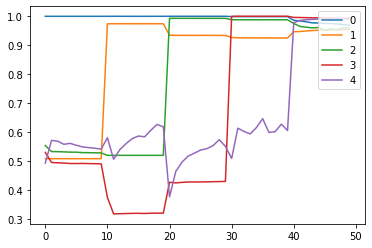

Total training time was 1061 s.


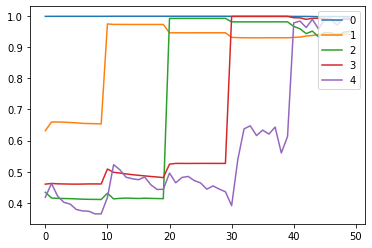

Total training time was 931 s.


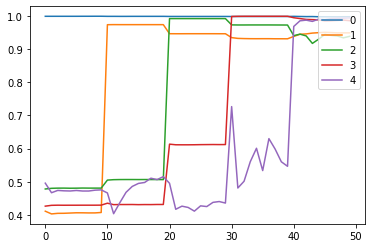

Total training time was 926 s.


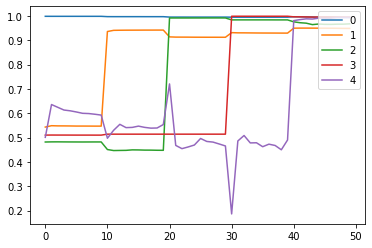

Total training time was 924 s.


0

In [40]:
# Some parameters
n_units = 256
lr = 0.5
init_methods = ['clone']#, 'xavier', 'exp']
tau = 0.5
epochs = 10
epoch_steps = 0
batch_steps = 50
layers = [4,5]
# Initialize model and params
for k in range(4):
    model = CascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 1 
    nlayers = 6
    model.init_params(nlayers = nlayers, tau = tau, init_method ='clone', layers = layers)
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                                  trainloader, testloader, 
                                                  verbose = False, track_cascade = True if k==0 else False, 
                                                  plot_rt = True,
                                                 evolve_cascade_pb = batch_steps)
                                                  #copy_cascade_after_epoch = (3,0.25),   
    if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
    data_dict[f"inner_layers_only_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
    weight_snaps.append(data["full_weight_snaps"])
    v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
    datas.append(data)
    val_acc.append(v_a)
    tr_acc.append(t_a)
    val_l.append(v_l)
    tr_l.append(t_l)
plot_params(data, nlayers)

In [41]:
# print("Average accuracy no cascade:", np.mean(val_acc[0][-1,:]))
# print(v_a[-1,:])

In [42]:
# Second saving checkpoint
with open(data_dir+"only-last.json","w+") as file:
    json.dump(data_dict,file)

# Shuffled MNIST

In [43]:
ntasks = 10
traindata, testdata = grab_data(data_dir, "shuffledMNIST", ntasks = ntasks)
# So, in the simulations it seems that 128 is better than 64 for splitMNIST, 64 is slower and doesn't perform significantly better
batch_size = 256
trainloader = torch.utils.data.DataLoader(traindata, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testdata, batch_size = batch_size, shuffle = True)

# No cascade Shuffled MNIST

In [44]:
# The best accuracy I can get here is with lr = 1e-2 using SGD
n_units = 2000
lr = 5e-2
myvals = []
for k in range(4):
    # Initialize model and params
    model = FakeCascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, 10, trainloader, testloader, verbose = False, adam = False)
    if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
    data_dict[f"shuffled_no_cascade_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
    myvals.append(np.array(v_a)[-1,:])
plot_accuracy(t_a)

In [45]:
# acc_no = np.array(v_a)[-1,:]
# plt.plot(np.array(v_a)[-1,:], marker = '.', markersize = 15)
# plt.grid(True)

# Shuffled MNIST with best model

In [46]:
# Some parameters
n_units = 2000
lr = 0.5
init_methods = ['clone']#, 'xavier', 'exp']
tau = 0.25
epochs = 10
epoch_steps = 0
batch_steps = 200
layers = [2,3,4,5]
# Initialize model and params
for k in range(4):
    model = CascadeSequential(
            nn.Flatten(),
            nn.Linear(28*28, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 10),
            Masked_Softmax(10)
    )
    model.init_multiplyer = 1 
    nlayers = 7
    model.init_params(nlayers = nlayers, tau = tau, init_method ='clone', layers = layers)
    model.lr = lr
    #print(device)
    model.to(device)
    #print(model.cascade[0][1].device)
    optim = torch.optim.SGD(model.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    # Run training
    t_l, v_l, t_a, v_a, data = multitask_training(model, optim, loss, device, epochs, 
                                                  trainloader, testloader, 
                                                  verbose = False, track_cascade = False, 
                                                  plot_rt = True, evolve_cascade_pe = epoch_steps,
                                                 evolve_cascade_pb = batch_steps)
                                                  #copy_cascade_after_epoch = (3,0.25),  
    if type(data["cascade_evolution"]) == torch.Tensor:
        data["cascade_evolution"] = data["cascade_evolution"].tolist()
    data_dict[f"shuffled_best_{k}"] = {"training": [t_l,t_a],"validation": [v_l,v_a], "weight_data": data, "lr": lr}
    weight_snaps.append(data["full_weight_snaps"])
    
v_a, t_a, t_l, v_l = np.array(v_a), np.array(t_a), np.array(t_l), np.array(v_l)
datas.append(data)
val_acc.append(v_a)
tr_acc.append(t_a)
val_l.append(v_l)
tr_l.append(t_l)
plot_params(data, nlayers)

In [47]:
# # Second saving checkpoint
# with open(data_dir+"results-shuffled.json","w+") as file:
#     json.dump(data_dict,file)

In [48]:
# plot_accuracy(t_a)

In [49]:
# acc_yes = np.array(v_a)[-1,:]
# plt.plot(v_a[-1,:], marker = '.', markersize = 15)
# plt.grid(True)

In [50]:
# plt.plot(acc_no, marker = '.', markersize = 15)
# plt.plot(acc_yes, marker = '.', markersize = 15)
# plt.grid(True)

# Convolutional network?

My hypothesis is that by using very high resting times the following two things will happen:
- Small fluctuations get absorbed by the cascade and do not really influence the weights of the previous tasks, which have stabilized into a more or less rest configuration
- Large fluctuations have the time to be incorporated into the cascade, and the weights can settle into new states and become more stabilised. The problem with this is that the cascades are not REALLY settling and will slowly decay back to their original configuration (and then towards zero). 

Maybe I should come up with an update for the cascades which resets their values in some way?

## Note on Adam
Adam is a bad choice for continual learning, due to the long memory that the gradients contain. SGD is much better, both in the case of naive bayes and in the case of the cascade.
